In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import TimesNet


/home/maybe/miniconda3/envs/task2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-16 12:54:40,146	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-16 12:54:40,226	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# 1. Загрузка и подготовка данных
df = pd.read_csv('evs1_012_10_bar_harmonics_median_new.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# 2. Расчёт разностей (delta_y — приращение на день, учитывая неравномерные дельты)
df['delta_t'] = df['date'].diff().dt.total_seconds() / (24*3600)
df['delta_y'] = df['value'].diff() / df['delta_t']
df = df.dropna().reset_index(drop=True)

# 3. Формирование датасета для TimesNet
df_train = pd.DataFrame({
    'unique_id': 'series1',
    'ds': df['date'],
    'y': df['delta_y'],
})

In [3]:
# 4. Инициализация и обучение TimesNet
model = TimesNet(
    input_size=120,
    h=30,
    max_steps=55,
)
nf = NeuralForecast(models=[model], freq='D')
nf.fit(df_train)

Seed set to 1
/home/maybe/miniconda3/envs/task2/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | T

Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, v_num=217, train_loss_step=0.376, train_loss_epoch=0.376]

`Trainer.fit` stopped: `max_steps=55` reached.


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s, v_num=217, train_loss_step=0.376, train_loss_epoch=0.376]


In [4]:
# 5. Прогнозирование
forecast = nf.predict()
yhat_delta_y = forecast['TimesNet'].values  # Предсказанные приращения

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


In [5]:
# 6. Восстановление абсолютных значений
last_value = df['value'].iloc[-1]
restored = [last_value]
for dy in yhat_delta_y:
    # Здесь предполагается dt=1 (день); можно использовать типовую дельту
    restored.append(restored[-1] + dy * 1)
restored = restored[1:]  # убираем старое значение, интересуют только прогнозы

In [6]:
# 7. Генерация дат для прогноза
last_date = df['date'].iloc[-1]
forecast_dates = [last_date + pd.Timedelta(days=i+1) for i in range(len(restored))]

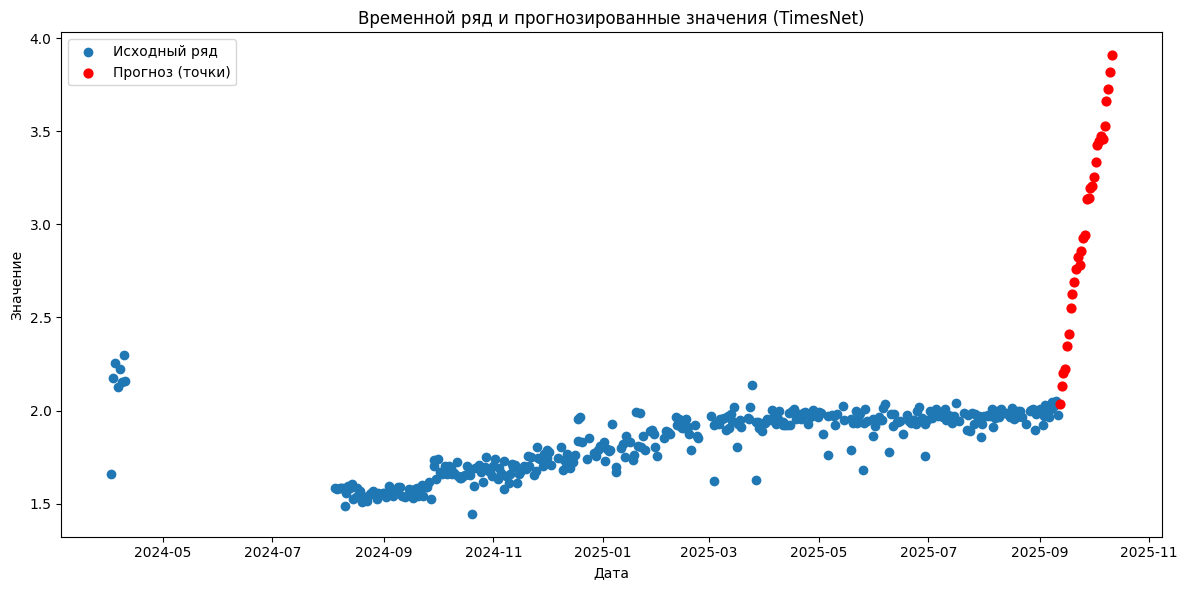

In [7]:
# 8. Визуализация
plt.figure(figsize=(12,6))
plt.scatter(df['date'], df['value'], label='Исходный ряд', lw=1)
plt.scatter(forecast_dates, restored, color='red', label='Прогноз (точки)', s=40, zorder=3)
plt.title('Временной ряд и прогнозированные значения (TimesNet)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.tight_layout()
plt.show()